<a href="https://colab.research.google.com/github/AkhilVinayakp/HAR_LSTM_CNN/blob/main/lstm_cnn_model_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%cd /content/drive/My\ Drive/datasets 
%pwd

/content/drive/My Drive/datasets


'/content/drive/My Drive/datasets'

In [4]:

df =  pd.read_csv('int_norm.csv')

In [5]:
df.shape

(1098204, 6)

In [6]:
def create_windowed_dataset(series, window_size,shift_size, batch_size,shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size , shift = shift_size, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size))
  dataset = dataset.map(lambda window: ( window[:,1:], tf.one_hot(tf.cast(window[window_size -1 , 0], tf.int64), depth=6) ))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
df.drop('timestamp', axis = 1, inplace=True)

In [8]:
df.activity = df.activity.astype('category').cat.codes
df.activity = df.activity.astype('int64')

In [9]:
train = df[df['user'] < 31 ]
test = df[df['user'] > 30]

In [10]:
train.drop('user', axis = 1, inplace=True)
test.drop('user', axis = 1, inplace=True)
train.reset_index(drop = True, inplace = True)
test.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
print(train.shape)
print(test.shape)

(898361, 4)
(199843, 4)


In [12]:
print(train.shape)
print(test.shape)

(898361, 4)
(199843, 4)


In [13]:
train.head()

,activity,x-axis,y-axis,z-axis
0,5,0.058149,0.996847,-0.053996
1,5,-0.000000,0.998427,-0.056061
2,5,-0.023448,0.997247,-0.070345
3,5,0.014845,0.998642,-0.049932
4,5,0.014737,0.998072,-0.060286


In [14]:
test.head()

,activity,x-axis,y-axis,z-axis
0,1,-0.054655,0.997718,0.039652
1,1,0.405338,0.910910,0.077102
2,1,0.410782,0.911708,-0.006846
3,1,-0.032685,0.986373,0.161248
4,1,-0.083804,0.856341,0.509566


In [15]:
# creating test set
def create_test_windowed(series, window_size = 128):
  test = tf.data.Dataset.from_tensor_slices(series)
  test = test.window(window_size, drop_remainder = True)
  test = test.flat_map(lambda window: window.batch(window_size))
  test = test.map(lambda window: (window[:,1:], tf.one_hot(tf.cast(window[window_size -1 , 0], tf.int64), depth=6)))
  return test

In [16]:
test_win = create_test_windowed(test)   # test data set for evaluation

In [17]:
test_data = list(test_win.as_numpy_iterator())

In [18]:
test_f = []
test_l = []
for i in test_data:
  test_f.append(i[0])
  test_l.append(i[1])

In [19]:
test_f = np.array(test_f)

In [20]:
test_f.shape

(1561, 128, 3)

In [21]:
test_f.shape

(1561, 128, 3)

In [22]:

test_l = np.array(test_l)

In [23]:
test_l.shape

(1561, 6)

In [24]:
x_val = test_f[:200]
y_val = test_l[:200]
print(x_val.shape)
print(y_val.shape)

(200, 128, 3)
(200, 6)


In [25]:
train_windowed = create_windowed_dataset(train, 128, 64, 200, 128)

In [26]:
# # adding globel average pooling to the model
# codding lstm layers and cnn
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,
                      input_shape=[128, 3]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dropout(.4),
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Conv2D(64,5,strides=(2,2)),
  tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  
  tf.keras.layers.Conv2D(128,3,strides=(1,1)),  
  tf.keras.layers.GlobalAveragePooling2D(),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # parameters ?
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation='softmax')
  
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128, 3)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 128, 32)           4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 32)           8320      
_________________________________________________________________
dropout (Dropout)            (None, 128, 32)           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 32, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 14, 64)        1664      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 7, 64)         0

In [28]:
# designing class back to save the best model
from tensorflow.keras.callbacks import ModelCheckpoint
save = ModelCheckpoint('best_trained_model.h5', save_best_only = True)

In [29]:

train = train_windowed.take(round(13654*0.7))
val = train_windowed.skip(round(13654*0.7))

In [30]:
# with out bidirection
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

history = model.fit(train_windowed,validation_data=(test_f, test_l), epochs=200,callbacks=[save], verbose=1, batch_size=192) 

Epoch 1/200
71/71 [==============================] - 10s 68ms/step - loss: 1.3520 - accuracy: 0.6381 - val_loss: 1.6263 - val_accuracy: 0.3555
Epoch 2/200
71/71 [==============================] - 4s 54ms/step - loss: 0.9589 - accuracy: 0.7241 - val_loss: 1.5384 - val_accuracy: 0.3555
Epoch 3/200
71/71 [==============================] - 4s 53ms/step - loss: 0.9262 - accuracy: 0.7341 - val_loss: 1.4483 - val_accuracy: 0.3786
Epoch 4/200
71/71 [==============================] - 4s 53ms/step - loss: 0.8738 - accuracy: 0.7346 - val_loss: 1.4042 - val_accuracy: 0.3626
Epoch 5/200
71/71 [==============================] - 4s 53ms/step - loss: 0.8648 - accuracy: 0.7306 - val_loss: 1.4369 - val_accuracy: 0.3331
Epoch 6/200
71/71 [==============================] - 4s 52ms/step - loss: 0.8686 - accuracy: 0.7275 - val_loss: 1.9155 - val_accuracy: 0.3331
Epoch 7/200
71/71 [==============================] - 4s 54ms/step - loss: 0.8076 - accuracy: 0.7462 - val_loss: 2.7676 - val_accuracy: 0.3331
Epoch

In [ ]:
# model.save('prime_model.h5')

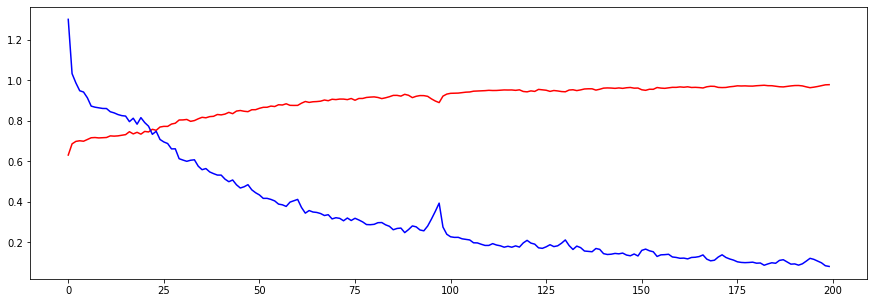

In [31]:
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['loss'], color = 'b')

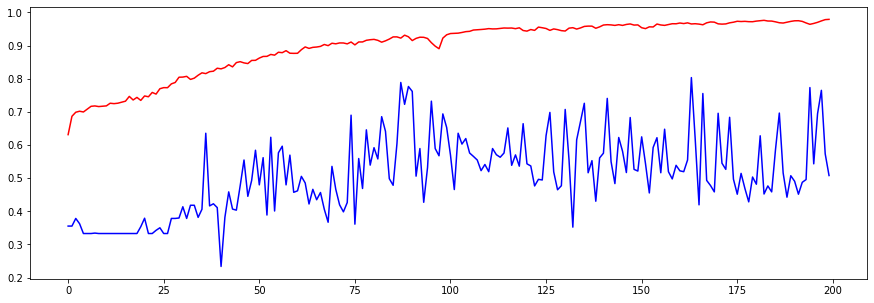

In [32]:
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['val_accuracy'], color = 'b')
# plt.legend()

In [33]:
eval = model.evaluate(test_f,test_l)

49/49 [==============================] - 0s 8ms/step - loss: 2.4031 - accuracy: 0.5080


In [34]:
b_model = tf.keras.models.load_model('best_trained_model.h5')

In [35]:
b_model.evaluate(test_f, test_l)

49/49 [==============================] - 1s 8ms/step - loss: 0.7374 - accuracy: 0.8033


[0.737353503704071, 0.803331196308136]

In [36]:
test_pred = b_model.predict_classes(test_f)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [37]:
test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [38]:
test_l.shape

(1561, 6)

In [41]:
from sklearn.preprocessing import OneHotEncoder

In [43]:

test_pr = OneHotEncoder().fit_transform(test_pred.reshape(-1,1))

In [44]:
test_pr.shape

(1561, 6)

In [45]:
con = tf.math.confusion_matrix(test_l, test_pr)

ValueError: ignored

In [53]:
# # adding globel average pooling to the model
# codding lstm layers and cnn
model_bi_dir = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: x,
                      input_shape=[128, 3]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.SpatialDropout1D(0.4),
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  tf.keras.layers.Conv2D(64,5,strides=(2,2)),
  tf.keras.layers.MaxPooling2D((2, 2), strides = (2,2)),
  
  tf.keras.layers.Conv2D(128,3,strides=(1,1)),  
  tf.keras.layers.GlobalAveragePooling2D(),
  # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
  # parameters ?
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(6, activation='softmax')
  
])

In [54]:
model_bi_dir.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 128, 3)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 64)           9216      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128, 64)           24832     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 128, 64)           0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 128, 64, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 30, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 15, 64)       

In [55]:
from tensorflow.keras.callbacks import ModelCheckpoint
save_bi = ModelCheckpoint('best_trained_model_bi.h5', save_best_only = True)

In [56]:
optimizer = tf.keras.optimizers.Adam(0.001)
model_bi_dir.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics = ['accuracy'])

history = model_bi_dir.fit(train_windowed, validation_data=(test_f, test_l), epochs=200,callbacks=[save], verbose=1, batch_size=192)

Epoch 1/200
71/71 [==============================] - 10s 84ms/step - loss: 1.3896 - accuracy: 0.5678 - val_loss: 1.6061 - val_accuracy: 0.3555
Epoch 2/200
71/71 [==============================] - 5s 64ms/step - loss: 1.0909 - accuracy: 0.6656 - val_loss: 1.5498 - val_accuracy: 0.3555
Epoch 3/200
71/71 [==============================] - 5s 64ms/step - loss: 1.0026 - accuracy: 0.6953 - val_loss: 1.5222 - val_accuracy: 0.3555
Epoch 4/200
71/71 [==============================] - 5s 65ms/step - loss: 0.9430 - accuracy: 0.7129 - val_loss: 1.4389 - val_accuracy: 0.3555
Epoch 5/200
71/71 [==============================] - 5s 64ms/step - loss: 0.9201 - accuracy: 0.7082 - val_loss: 1.3466 - val_accuracy: 0.3799
Epoch 6/200
71/71 [==============================] - 5s 64ms/step - loss: 0.9041 - accuracy: 0.7128 - val_loss: 1.2877 - val_accuracy: 0.5093
Epoch 7/200
71/71 [==============================] - 5s 63ms/step - loss: 0.8689 - accuracy: 0.7236 - val_loss: 1.4672 - val_accuracy: 0.3690
Epoch

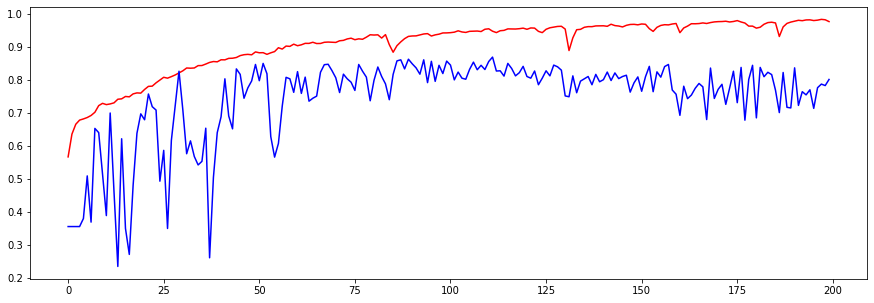

In [57]:
m_acc = history.history['accuracy']
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(m_acc, color = 'r')
ax.plot(history.history['val_accuracy'], color = 'b')
# plt.legend()

In [60]:
b_model = tf.keras.models.load_model('best_trained_model_bi.h5')

OSError: ignored

In [ ]:
# hyperparameter tuning
# creating a fuction that will return a model
def build_model_fn():
  pass